# MODELOS DE REDES PARA DENGUE FLORIDABLANCA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Floridablanca_Lags.csv', encoding='latin-1', sep=";")
datos.columns

Index(['Municipio', 'Año', 'Semana_Epi', 'Casos_Dengue', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6',
       'Total_Preci_Sem', 'Total_Preci_Sem_1', 'Total_Preci_Sem_2',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5',
       'Total_Preci_Sem_6'],
      dtype='object')

In [3]:
# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_6',
                    'Prom_Dia_Preci_2', 'Prom_Dia_Preci_1', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
                    'Total_Preci_Sem', 'Total_Preci_Sem_6', 'Total_Preci_Sem_2',
                    'Total_Preci_Sem_1', 'Total_Preci_Sem_3', 'Total_Preci_Sem_4'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_5', 'Total_Preci_Sem_5'], dtype='object')

In [4]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_5     0
Total_Preci_Sem_5    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Prom_Dia_Preci_5', 'Total_Preci_Sem_5']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [9]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [10]:
Flori_LSTM_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Flori_LSTM_model_2.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Flori_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Flori_LSTM_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Flori_LSTM_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Flori_LSTM_model_6.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Flori_LSTM_model_2.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Flori_LSTM_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 10s - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0147 - val_mse: 0.0147 - 10s/epoch - 721ms/step
Epoch 2/100
14/14 - 1s - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0079 - val_mse: 0.0079 - 596ms/epoch - 43ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0074 - val_mse: 0.0074 - 495ms/epoch - 35ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0079 - val_mse: 0.0079 - 416ms/epoch - 30ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0020 - val_mse: 0.0020 - 483ms/epoch - 34ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0046 - val_mse: 0.0046 - 462ms/epoch - 33ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0036 - val_mse: 0.0036 - 451ms/epoch - 32ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0061 - val_mse: 0.0061 - 454ms/epoch - 32ms/step
Epoch 9/100
14/14 - 1s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0040 - val_mse

# MODELO CNN

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [12]:
Flori_CNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Flori_CNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Flori_CNN_model_2.add(keras.layers.Conv1D(220, kernel_size=2, strides=1, activation='tanh', padding='same'))
Flori_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Flori_CNN_model_2.add(keras.layers.Conv1D(200, kernel_size=2, strides=1, activation='tanh', padding='same'))
Flori_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Flori_CNN_model_2.add(Dropout(0.1))
Flori_CNN_model_2.add(Flatten())
    
Flori_CNN_model_2.add(keras.layers.Dense(units=128, activation='tanh'))
Flori_CNN_model_2.add(Dropout(0.1)) 


#CAPA DE SALIDA                 
Flori_CNN_model_2.add(Dense(1))


#COMPILACIÓN DEL MODELO
Flori_CNN_model_2.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Flori_CNN_model_6.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Flori_CNN_model_2.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Flori_CNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 2s - loss: 0.0667 - mse: 0.0667 - val_loss: 0.0016 - val_mse: 0.0016 - 2s/epoch - 140ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0061 - val_mse: 0.0061 - 152ms/epoch - 11ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0023 - val_mse: 0.0023 - 194ms/epoch - 14ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0012 - val_mse: 0.0012 - 203ms/epoch - 14ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0026 - val_mse: 0.0026 - 163ms/epoch - 12ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0100 - val_mse: 0.0100 - 177ms/epoch - 13ms/step


# MODELO RNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [14]:
Flori_RNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Flori_RNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Flori_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Flori_RNN_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Flori_RNN_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Flori_RNN_model_6.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Flori_RNN_model_2.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Flori_RNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 7s - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0074 - val_mse: 0.0074 - 7s/epoch - 467ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0055 - val_mse: 0.0055 - 297ms/epoch - 21ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0039 - val_mse: 0.0039 - 259ms/epoch - 19ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0088 - val_mse: 0.0088 - 190ms/epoch - 14ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0068 - val_mse: 0.0068 - 191ms/epoch - 14ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0064 - val_mse: 0.0064 - 201ms/epoch - 14ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0107 - val_mse: 0.0107 - 201ms/epoch - 14ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0022 - val_mse: 0.0022 - 249ms/epoch - 18ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0019 - val_mse: 

# MODELO GRU

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(429, 7, 3) (429,) (181, 7, 3) (181,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [16]:
Flori_GRU_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Flori_GRU_model_2.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Flori_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Flori_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Flori_GRU_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Flori_GRU_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Flori_GRU_model_6.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Flori_GRU_model_2.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Flori_GRU_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 12s - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0046 - val_mse: 0.0046 - 12s/epoch - 831ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0052 - val_mse: 0.0052 - 477ms/epoch - 34ms/step
Epoch 3/100
14/14 - 1s - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0028 - val_mse: 0.0028 - 559ms/epoch - 40ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0040 - val_mse: 0.0040 - 409ms/epoch - 29ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0038 - val_mse: 0.0038 - 391ms/epoch - 28ms/step
Epoch 6/100
14/14 - 1s - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0048 - val_mse: 0.0048 - 520ms/epoch - 37ms/step
Epoch 7/100
14/14 - 1s - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0025 - val_mse: 0.0025 - 668ms/epoch - 48ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0049 - val_mse: 0.0049 - 421ms/epoch - 30ms/step


### Graficas de función de pérdida & RMSE

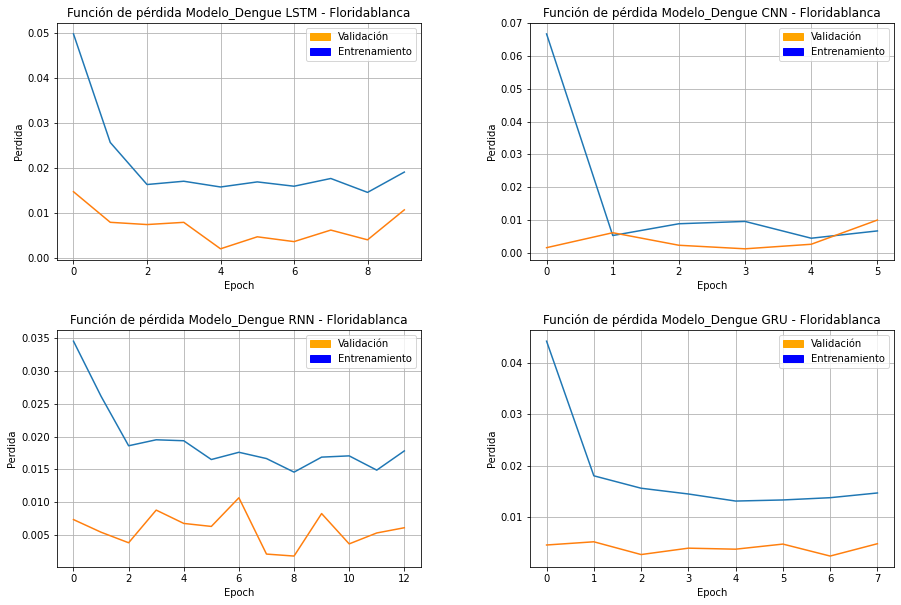

In [17]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue LSTM - Floridablanca')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue CNN - Floridablanca')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue RNN - Floridablanca')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue GRU - Floridablanca')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 1s 7ms/step


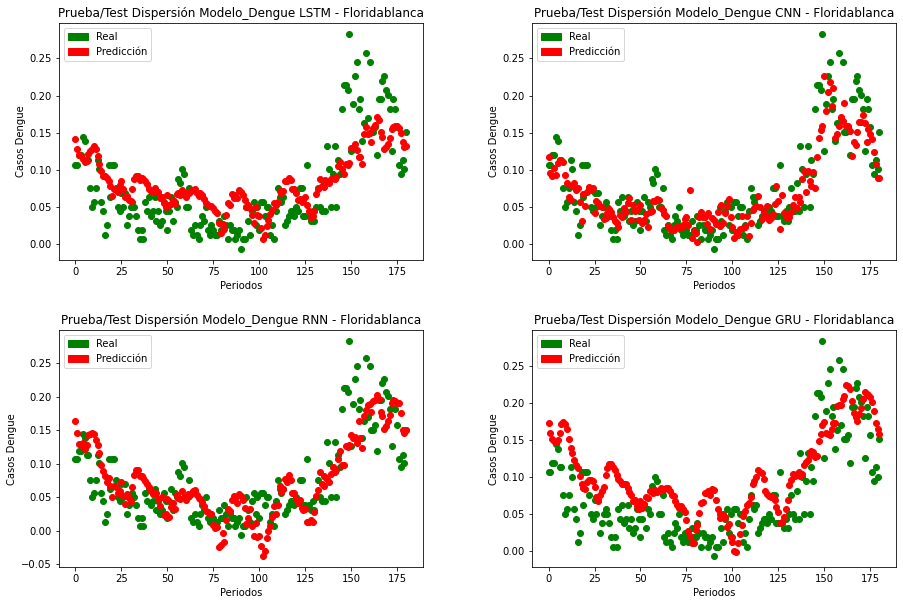

In [18]:
results_LSTM =Flori_LSTM_model_2.predict(X_test_LSTM)
results_CNN =Flori_CNN_model_2.predict(X_test_CNN)
results_RNN =Flori_RNN_model_2.predict(X_test_RNN)
results_GRU =Flori_GRU_model_2.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue LSTM - Floridablanca')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue CNN - Floridablanca')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue RNN - Floridablanca')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue GRU - Floridablanca')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [19]:
y_pred_LSTM = Flori_LSTM_model_2.predict(X_test_LSTM)
y_pred_CNN = Flori_CNN_model_2.predict(X_test_CNN)
y_pred_RNN = Flori_RNN_model_2.predict(X_test_RNN)
y_pred_GRU = Flori_GRU_model_2.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 8ms/step


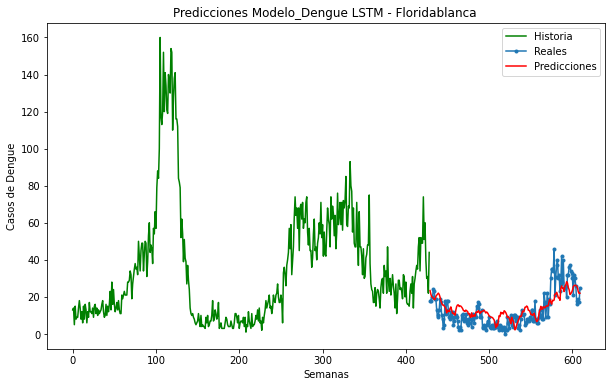

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue LSTM - Floridablanca ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

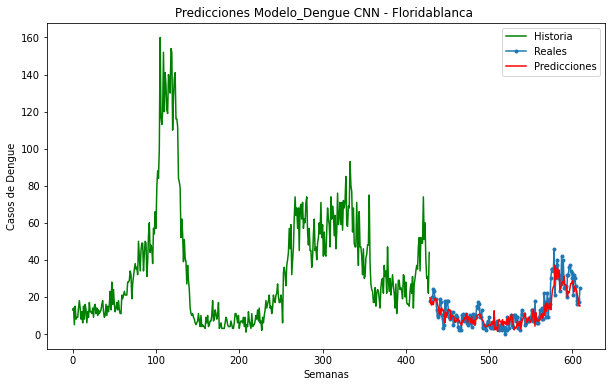

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue CNN - Floridablanca ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

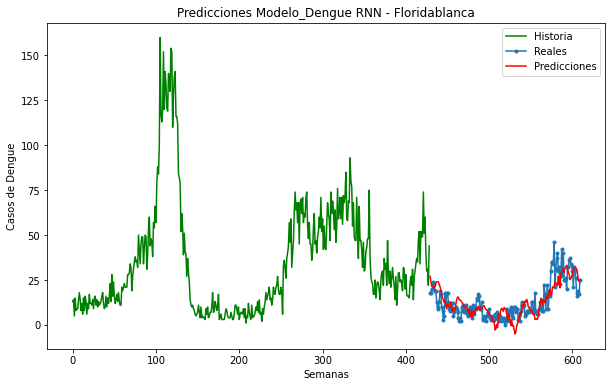

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue RNN - Floridablanca')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

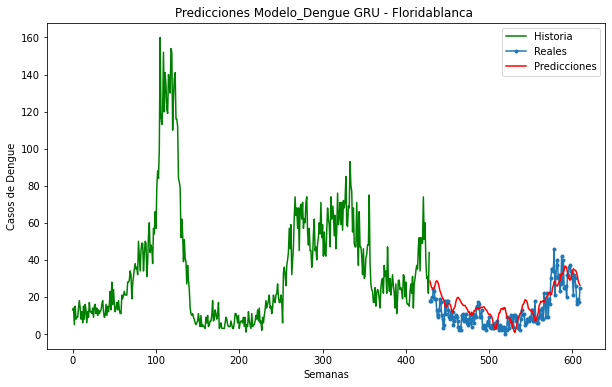

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue GRU - Floridablanca ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

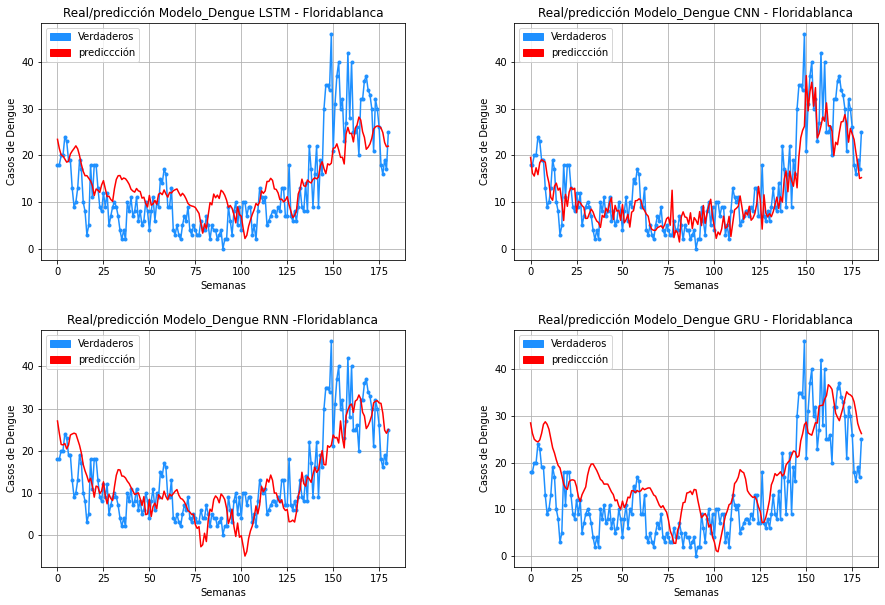

In [24]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue LSTM - Floridablanca' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue CNN - Floridablanca' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue RNN -Floridablanca' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue GRU - Floridablanca' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [25]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo_2 LSTM Dengue Floridablanca : {}".format(score_LSTM))
print("RMSE Modelo_2  CNN Dengue  Floridablanca  : {}".format(score_CNN))
print("RMSE Modelo_2  RNN Dengue  Floridablanca: {}".format(score_RNN))
print("RMSE Modelo_2  GRU Dengue  Floridablanca  : {}".format(score_GRU))

RMSE Modelo_2 LSTM Dengue Floridablanca : 7.06761559575153
RMSE Modelo_2  CNN Dengue  Floridablanca  : 5.540737900664335
RMSE Modelo_2  RNN Dengue  Floridablanca: 6.846322326870073
RMSE Modelo_2  GRU Dengue  Floridablanca  : 7.91108994713202


In [26]:
print("MSE Modelo_2  LSTM Dengue Floridablanca  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo_2  CNN Dengue Floridablanca   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo_2  RNN Dengue Floridablanca   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo_2  GRU Dengue Floridablanca   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo_2  LSTM Dengue Floridablanca  =  49.95119020931025
MSE Modelo_2  CNN Dengue Floridablanca   =  30.699776483858226
MSE Modelo_2  RNN Dengue Floridablanca   =  46.87212940339965
MSE Modelo_2  GRU Dengue Floridablanca   =  62.58534415161332


In [27]:
print("MAE Modelo_2  LSTM Dengue Floridablanca = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo_2  CNN Dengue Floridablanca  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo_2  RNN Dengue Floridablanca  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo_2  GRU Dengue Floridablanca = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo_2  LSTM Dengue Floridablanca =  5.538694496312853
MAE Modelo_2  CNN Dengue Floridablanca  =  4.173539402735168
MAE Modelo_2  RNN Dengue Floridablanca  =  5.312539849080434
MAE Modelo_2  GRU Dengue Floridablanca =  6.595668005350545


In [28]:
print("r2_score Modelo_2  LSTM Dengue Floridablanca  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo_2  CNN Dengue Floridablanca = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo_2  RNN Dengue Floridablanca  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo_2  GRU Dengue Floridablanca = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo_2  LSTM Dengue Floridablanca  =  0.49713546300040956
r2_score Modelo_2  CNN Dengue Floridablanca =  0.6909417208507501
r2_score Modelo_2  RNN Dengue Floridablanca  =  0.528132732135935
r2_score Modelo_2  GRU Dengue Floridablanca =  0.36994594167057304


In [29]:
print("explained_variance_score Modelo_2  LSTM Dengue Floridablanca  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo_2  CNN Dengue Floridablanca  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo_2  RNN Dengue Floridablanca  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo_2  GRU Dengue Floridablanca  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo_2  LSTM Dengue Floridablanca  =  0.509782721542639
explained_variance_score Modelo_2  CNN Dengue Floridablanca  =  0.7028028960112848
explained_variance_score Modelo_2  RNN Dengue Floridablanca  =  0.5282744321162065
explained_variance_score Modelo_2  GRU Dengue Floridablanca  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [30]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0      18.0     23.437775    5.437775
1      18.0     21.466505    3.466505
2      20.0     20.092558    0.092558
3      20.0     19.871067   -0.128933
4      24.0     19.223833   -4.776167
     Actuales  Predicciones  diferencia
176      18.0     25.878401    7.878401
177      16.0     24.892019    8.892019
178      19.0     22.761908    3.761908
179      17.0     21.846205    4.846205
180      25.0     21.979097   -3.020903


In [31]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0      18.0     19.564034    1.564034
1      18.0     16.204931   -1.795069
2      20.0     15.574061   -4.425939
3      20.0     17.350061   -2.649939
4      24.0     15.870768   -8.129232
     Actuales  Predicciones  diferencia
176      18.0     23.421392    5.421392
177      16.0     20.663059    4.663059
178      19.0     18.209341   -0.790659
179      17.0     15.057838   -1.942162
180      25.0     15.240514   -9.759486


In [32]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0      18.0     27.043766    9.043766
1      18.0     24.141069    6.141069
2      20.0     21.471111    1.471111
3      20.0     21.362127    1.362127
4      24.0     21.703938   -2.296062
     Actuales  Predicciones  diferencia
176      18.0     31.235836   13.235836
177      16.0     28.922443   12.922443
178      19.0     24.854481    5.854481
179      17.0     24.120941    7.120941
180      25.0     25.018860    0.018860


In [33]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0      18.0     28.497471   10.497471
1      18.0     26.269461    8.269461
2      20.0     25.015318    5.015318
3      20.0     24.628607    4.628607
4      24.0     24.425055    0.425055
     Actuales  Predicciones  diferencia
176      18.0     33.039349   15.039349
177      16.0     30.974495   14.974495
178      19.0     28.408934    9.408934
179      17.0     27.130764   10.130764
180      25.0     26.223211    1.223211
